# OSRS FLIPPING

In [2]:
import pandas as pd
import requests as req
import json

### Initialises dataframe

In [4]:
baseURL = "https://rsbuddy.com/exchange/summary.json";

call = req.request("GET",url=baseURL)
temp = pd.read_json(call.text)

df = temp.transpose()

def get_margin_price(row):
    if(row["sell_average"] > row["buy_average"]):
        return row["sell_average"]-row["buy_average"]
    else:
        return row["buy_average"]-row["sell_average"]    
      
def get_margin_quantity(row):
    if(row["sell_quantity"]> row["buy_quantity"]):
        return row["sell_quantity"]-row["buy_quantity"]
    else:
        return row["buy_quantity"]-row["sell_quantity"]
    

df["margin_price"] = df.apply(lambda row: get_margin_price(row), axis=1 )
df["margin_quantity"] = df.apply(lambda row: get_margin_quantity(row), axis=1)

df = df[["id","name","members", "buy_average", "sell_average", "buy_quantity", "sell_quantity", "margin_price", "margin_quantity"]]
df.sample(5)

,id,name,members,buy_average,sell_average,buy_quantity,sell_quantity,margin_price,margin_quantity
97,97,Harralander potion (unf),True,0,847,0,2,847,2
1654,1654,Gold necklace,False,109,0,1,0,109,1
58,58,Willow longbow (u),True,0,51,0,1,51,1
2922,2922,Yellow gloves,False,850,0,1,0,850,1
1929,1929,Bucket of water,False,37,33,10,1704,4,1694


### Free to play items with good margins 

In [18]:
df_filtered = df[(df["buy_quantity"] > 1000) & (df["sell_quantity"] > 1000)]
df_filtered = df_filtered[df_filtered["margin_quantity"] < 1000]
df_filtered[df_filtered["members"]==False]  \
    .sort_values(by=["margin_price","margin_quantity"], ascending= [False, False])

,id,name,members,buy_average,sell_average,buy_quantity,sell_quantity,margin_price,margin_quantity
851,851,Maple longbow,False,218,205,2700,1935,13,765
1517,1517,Maple logs,False,8,7,15000,15088,1,88


## Get daily graph for item

In [29]:
import datetime
import plotly.graph_objects as go

In [24]:
base_URI = "http://services.runescape.com/m=itemdb_oldschool/api/graph/"
item = "Uncut sapphire"
itemIdDF = pd.read_csv("./data/AllItemIDs.csv")
itemID = itemIdDF.loc[itemIdDF["name"]==item]['id'].item()
print(itemID)

1623


In [25]:
r =req.get(base_URI+str(itemID)+".json")
r
if r.status_code == 200:
    json_data = json.loads(r.text)
    dailyPriceJSON = json_data['daily']
else:
    print("There has been an error making the request. Error code: "+ str(r.status_code))

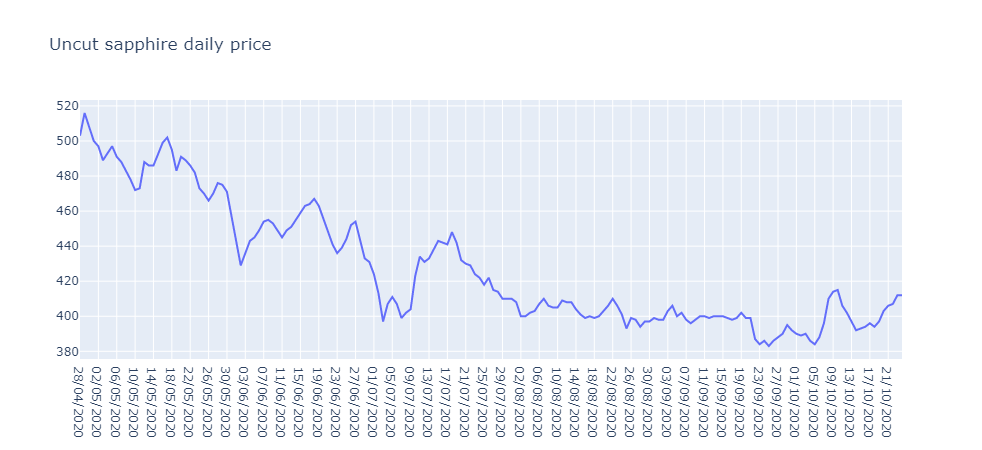

In [35]:
def convert_to_datetime(row):
    epoch_time = str(row['timestamp'])[0: 10]
    return datetime.datetime.fromtimestamp(float(epoch_time)).strftime('%d/%m/%Y')

dailyPriceDF = pd.DataFrame(dailyPriceJSON.items(), columns= ["timestamp", "price"])
dailyPriceDF['timestamp_formatted'] = dailyPriceDF.apply(lambda row: convert_to_datetime(row), axis=1)
dailyPriceDF
fig = go.Figure(data=go.Scatter(x=dailyPriceDF['timestamp_formatted'], y=dailyPriceDF['price']))
fig.update_layout(title=item + " daily price")
fig.show()

### Member item list

In [67]:
df_members = df.loc[df["members"]==True][["name", "buy_average", "sell_average", "buy_quantity", "margin"]]
df_members

,name,buy_average,sell_average,buy_quantity,margin
2,Cannonball,146,145,329621,1
6,Cannon base,185503,184352,1,1151
8,Cannon stand,188064,187105,1,959
10,Cannon barrels,185260,185061,1,199
12,Cannon furnace,189715,188536,1,1179
28,Insect repellent,184,0,1,184
30,Bucket of wax,1450,0,5,1450
36,Candle,585,525,16,60
39,Bronze arrowtips,6,5,2300,1
40,Iron arrowtips,12,8,8105,4


### Non member list sorted by buy quantity

In [7]:
df_non_members = df[df["members"]==False] [["name", "buy_average", "sell_average", "buy_quantity", "margin"]]
df_non_members.sort_values(by="buy_quantity", ascending= False)

,name,buy_average,sell_average,buy_quantity,margin
560,Death rune,206,208,550522,2
562,Chaos rune,77,78,524588,1
554,Fire rune,4,4,505960,0
447,Mithril ore,139,143,388606,4
7936,Pure essence,2,2,306968,0
556,Air rune,4,4,257025,0
2353,Steel bar,383,380,232335,3
561,Nature rune,207,206,211453,1
314,Feather,2,2,199028,0
453,Coal,142,141,196803,1
